In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Conv2D, SeparableConv2D, Flatten, Dropout, MaxPooling2D, \
    BatchNormalization, ReLU, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import os
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

In [25]:
use_colab = True
assert use_colab in [True, False]

In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
if use_colab:
    DATASET_PATH='Animals_10/raw-img'
else:
    DATASET_PATH='./'

In [28]:
# 딕셔너리 정의
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

In [29]:
# 클래스 레이블을 영어로 변환하는 함수
def translate_label(label):
    return translate[label]

In [30]:
# ImageDataGenerator를 사용하여 데이터셋 로드 및 변환
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

In [31]:

batch_size = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
# Train 데이터셋 로드
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # 다중 클래스 분류
    subset='training',  # 훈련 데이터
    shuffle=True
)

# Validation 데이터셋 로드
validation_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # 다중 클래스 분류
    subset='validation',  # 검증 데이터
    shuffle=False  # 검증 데이터는 섞지 않음
)



Found 21058 images belonging to 10 classes.
Found 5261 images belonging to 10 classes.


In [32]:
# Train 데이터셋의 샘플 수 확인
train_data_samples = train_data.samples
print(f"Training Data Samples: {train_data_samples}")

# Validation 데이터셋의 샘플 수 확인
validation_data_samples = validation_data.samples
print(f"Validation Data Samples: {validation_data_samples}")


Training Data Samples: 21058
Validation Data Samples: 5261


In [33]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

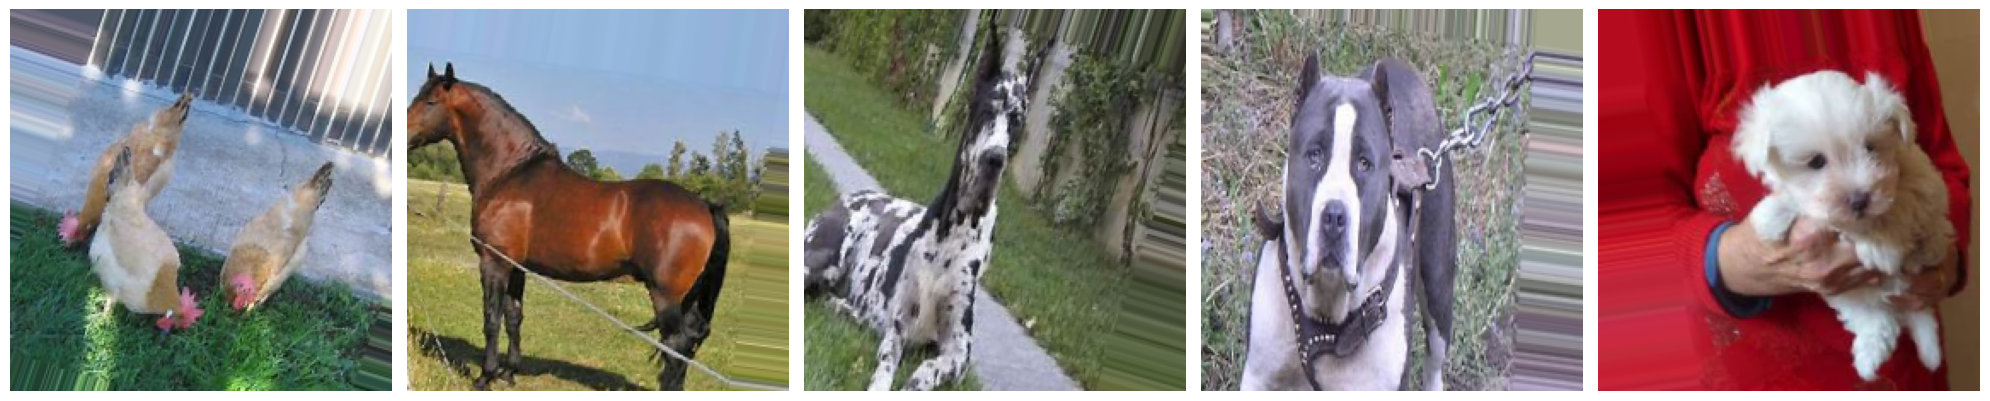

In [34]:
sample_training_images, _ = next(train_data)
plotImages(sample_training_images[:5])

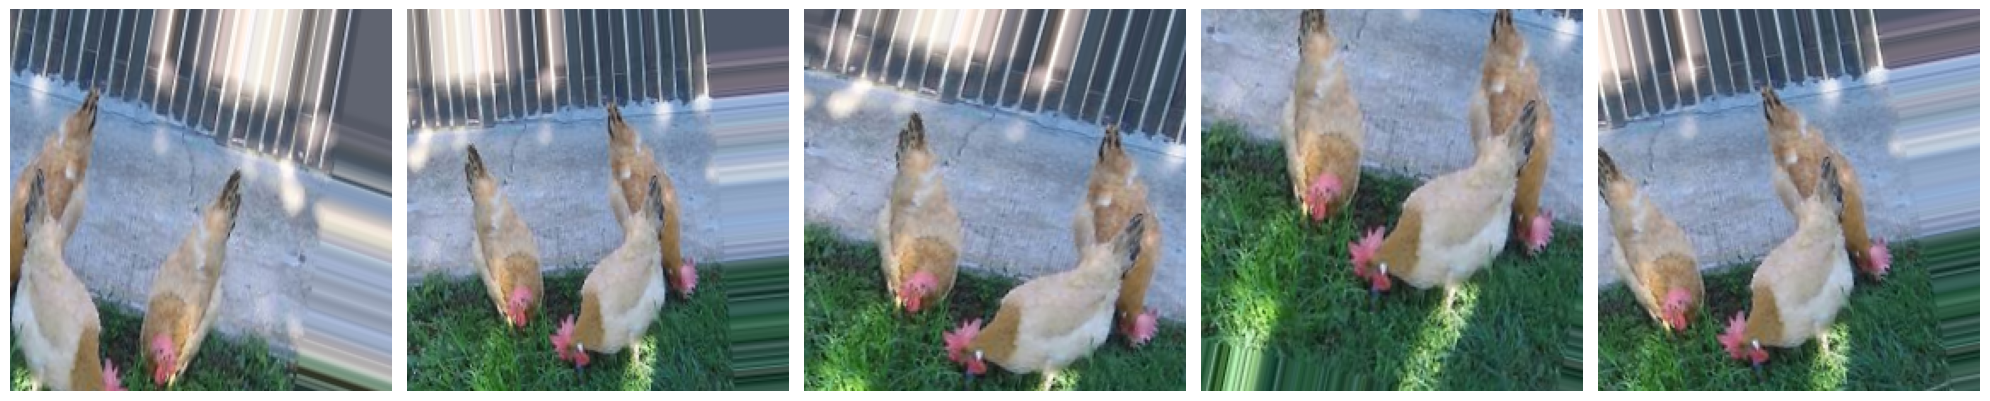

In [35]:
augmented_images = [train_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [36]:
# sample_images, sample_labels = next(iter(train_data))

In [37]:
# sample_images, sample_labels = next(iter(train_data))

# # 가져온 배치에서 하나의 이미지 선택
# sample_image = sample_images[0]
# sample_label = np.argmax(sample_labels[0])

# # 이미지를 시각화
# plt.imshow(sample_image)
# print(sample_labels[0])
# plt.show()

In [38]:
# # 이미지 및 라벨 출력
# for img, label in zip(images, labels):
#     print("Label:", label)
#     plt.imshow(img)
#     plt.show()


In [39]:
# # TensorFlow Dataset 생성
# dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# # 데이터 로더 함수 정의
# def data_loader(image, label):
#     image = tf.image.resize(image, (224, 224))  # 이미지 크기 조정
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # 이미지를 float32로 변환
#     return image, label

In [40]:
# for image, label in dataset.take(5):
#     # 이미지와 레이블 출력
#     print(f"Label: {label.numpy()}, Image Shape: {image.shape}")


In [41]:
class Mish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs * tf.math.tanh(tf.math.log(1 + tf.exp(inputs)))

In [42]:
# 클래스버젼 - Seperable Conv2D
class ResBlock(tf.keras.Model):
    def __init__(self, num_filter, stride=1, kernel_size=3, l2_reg=1e-4):
        super(ResBlock, self).__init__()
        self.num_filter = num_filter
        self.conv1 = layers.Conv2D(num_filter, kernel_size, strides=stride, padding='same',
                                   kernel_initializer=tf.keras.initializers.he_normal(),
                                   kernel_regularizer=regularizers.l2(0.001))
        self.se_conv1 = layers.SeparableConv2D(num_filter, kernel_size, padding='same',
                                               depthwise_initializer=tf.keras.initializers.he_normal(),
                                               pointwise_initializer=tf.keras.initializers.he_normal(),
                                               depthwise_regularizer=regularizers.l2(0.001),
                                               pointwise_regularizer=regularizers.l2(0.001))
        self.se_sonv2 = layers.SeparableConv2D(num_filter, kernel_size, padding='same',
                                               depthwise_initializer=tf.keras.initializers.he_normal(),
                                               pointwise_initializer=tf.keras.initializers.he_normal(),
                                               depthwise_regularizer=regularizers.l2(0.001),
                                               pointwise_regularizer=regularizers.l2(0.001))
        self.con_short = Conv2D(num_filter, 1, strides=2, padding='same',kernel_initializer=tf.keras.initializers.he_normal(),)
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        self.bn_short = BatchNormalization()
        self.mish = Mish()

    def call(self, input, stride=1):
        shortcut = input
        x = self.conv1(input)
        x = self.bn1(x)
        # x = layers.Activation('relu')(x)
        x = self.mish(x)
        x = self.se_conv1(x)
        x = self.bn2(x)
        x = self.se_sonv2(x)
        x = self.bn3(x)
        # 입력과 출력의 맞도록 숏컷을 조절
        if shortcut.shape[-1] != self.num_filter or stride != 1:
            shortcut = self.con_short(shortcut)
            shortcut = self.bn_short(shortcut)

        x = layers.Add()([x, shortcut])
        x = self.mish(x)
        return x


class ResNet28(tf.keras.Model):
    def __init__(self):
        super(ResNet28, self).__init__()
        self.conv1 = layers.Conv2D(64, 7, strides=2,
                                   kernel_initializer=tf.keras.initializers.he_normal(),
                                   padding='same')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.mish = Mish()

        self.blocks = [
                          ResBlock(64, stride=1) ] + [
                          ResBlock(128, stride=2),
                          # ResBlock(128, stride=1),
                          ResBlock(256, stride=2)] + [
                          ResBlock(256, stride=1) for _ in range(2)] + [
                          ResBlock(512, stride=2), ResBlock(512, stride=1)]

        #         self.blocks = [
        #                           ResBlock(64, stride=1) for _ in range(2)] + [
        #                           ResBlock(128, stride=2)] + [
        #                           ResBlock(128, stride=1) for _ in range(2)] + [
        #                           ResBlock(256, stride=2)] + [
        #                           ResBlock(256, stride=1) for _ in range(2)] + [
        #                           ResBlock(512, stride=2)] + [
        #                           ResBlock(512, stride=1)]

        self.avg_pool = GlobalAveragePooling2D()

        self.dropout = Dropout(0.5)
        self.out = Dense(10)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.mish(x)

        for block in self.blocks:
            x = block(x)

        x = self.avg_pool(x)
        x = layers.Dense(1000)(x)
        x = self.bn2(x)
        x = self.mish(x)
        x = self.dropout(x)
        x = self.out(x)

        return x


# Specify input shape and number of classes
input_tensor = layers.Input(shape=(224, 224, 3,))  # Example input shape for image classification

# Build ResNet model
Res = ResNet28()
output_tensor = Res.call(input_tensor)
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 112, 112, 64  256        ['conv2d_15[0][0]']              
 ormalization)                  )                                                           

In [43]:
initial_learning_rate = 2e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              # 0.0001~0.000001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
# the save point
if use_colab:
    checkpoint_dir = './drive/My Drive/train_ckpt/catsanddogs/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'catsanddogs/exp1'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     monitor='val_loss',
                                                     restore_best_weights=True,
                                                     verbose=1)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # 관찰할 지표
                              factor=0.2,  # 학습률을 줄이는 비율
                              patience=5,  # 몇 번의 에포크 동안 감소하지 않아야 하는지
                              min_lr=1e-9)

In [45]:
#model.load_weights(checkpoint_dir) # 모델이 완전히 같은 모양일 때만 동작합니다.
epochs = 100


history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=epochs,
    validation_data=validation_data,
    validation_steps=validation_data_samples // batch_size,
    callbacks=[cp_callback, early_stopping_cb, reduce_lr]
)

Epoch 1/100
1316/1316 [==============================] - ETA: 0s - loss: 10.6618 - accuracy: 0.3214
Epoch 1: val_loss improved from inf to 7.15747, saving model to ./drive/My Drive/train_ckpt/catsanddogs\exp1
1316/1316 [==============================] - 179s 133ms/step - loss: 10.6618 - accuracy: 0.3214 - val_loss: 7.1575 - val_accuracy: 0.4316 - lr: 2.0000e-04
Epoch 2/100
1316/1316 [==============================] - ETA: 0s - loss: 5.4557 - accuracy: 0.4709
Epoch 2: val_loss improved from 7.15747 to 4.18758, saving model to ./drive/My Drive/train_ckpt/catsanddogs\exp1
1316/1316 [==============================] - 171s 130ms/step - loss: 5.4557 - accuracy: 0.4709 - val_loss: 4.1876 - val_accuracy: 0.4945 - lr: 2.0000e-04
Epoch 3/100
1316/1316 [==============================] - ETA: 0s - loss: 3.4355 - accuracy: 0.5505
Epoch 3: val_loss improved from 4.18758 to 3.39109, saving model to ./drive/My Drive/train_ckpt/catsanddogs\exp1
1316/1316 [==============================] - 175s 133ms/st

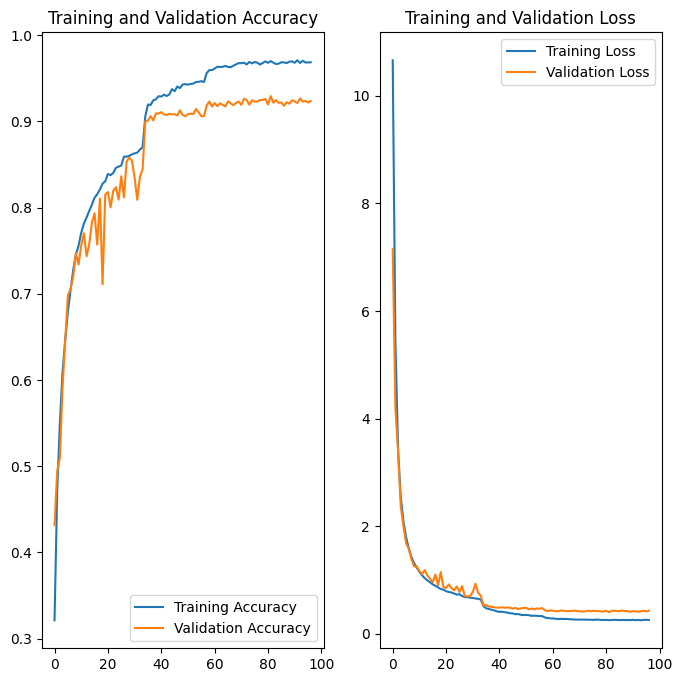

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(97)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
model.load_weights(checkpoint_dir)
eval = model.evaluate(validation_data)

329/329 [==============================] - 30s 90ms/step - loss: 0.4185 - accuracy: 0.9249


In [52]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(eval[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (eval[1] + min((1 / s), 1))

    print("score : " + str(score))

In [53]:
final_score()

Model params num : 7385570
Accuracy : 0.9249191880226135
score : 46.46779739061558
